<a href="https://colab.research.google.com/github/eorland/LSTM-Multistep-Prediction/blob/master/enc_dec_w_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#everything we will import to use later
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
from datetime import datetime, date, timedelta
import matplotlib
from matplotlib import pyplot as plt
from tensorflow.keras.models import model_from_json
import tensorflow_addons as tfa
from functions import rescale_no_pp, rescale_w_pp, lstm_prep_no_pp, lstm_prep_w_pp, rectify_cnn_data, mse_nan, mae_nan, evaluate_forecasts, threshold_rmse_eval, threshold_rmse_eval_rain, naive_forecast, add_max_rainfall, OrdinalToDatetime, predict

%matplotlib inline

import tensorflow.compat.v1 as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.layers import *
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tqdm.auto import tqdm, trange
from tqdm.keras import TqdmCallback
# import logging
# tf.get_logger().setLevel(logging.ERROR)
#check our version
# print(tf.VERSION)
# print(tf.keras.__version__)

In [3]:
def lstm_model_fn(forecast_hrs, dataset, ntrain, ntarg, features_input, targets_input, target_indices_input, epochs, batch_size, rmse_thresh): 
    forecast_hrs = forecast_hrs
    #pit_forecast = str(forecast_hrs)+"_1"
    ocr = pd.read_csv(data_path, index_col=0)
    #ocr = pd.read_csv('./SP1_processed.csv', index_col=0)
    pp_cols = [v for v in ocr.columns if "Pressure_" in v]  # measures number of features for pp
    #VWC_cols = [v for v in ocr.columns if "vwc_" in v]  # measures number of features for VWC

    num_targets = len(pp_cols)# + len(VWC_cols)
    ocr.index = pd.to_datetime(ocr.index)

    # scale data, no antecedant pp
    data = ocr
    data_scaling_features = preprocessing.MinMaxScaler(feature_range=(0,1)).fit(data.iloc[:,:-num_targets])
    data_scaled_df = pd.DataFrame(data_scaling_features.transform(data.iloc[:,:-num_targets]), index=ocr.index)
    data_scaling_targets = preprocessing.MinMaxScaler(feature_range=(0,1)).fit(data.iloc[:,-num_targets:])
    data_scaled_df = pd.concat([data_scaled_df, (pd.DataFrame(data_scaling_targets.transform(data.iloc[:,-num_targets:]), index=ocr.index))], axis = 1)
    data_scaled_df.fillna(-1, inplace=True)

    ntrain = ntrain  #how long should the antecedant window be?
    ntarg = ntarg  #this is the second and third variable, just good to keep them the same to cover all available data

    # finally, prepare features and targets
    # features, targets, target_indices = lstm_prep_no_pp(data_scaled_df.index.values, data_scaled_df.values[:,:-num_targets], 
    #                                               data_scaled_df.values[:,-num_targets:], num_targets, ntrain, ntarg)
    
    features = features_input
    targets = targets_input
    target_indices = target_indices_input

    # create bounds for the prediction intervals
    intervals = np.zeros(len(target_indices))
    for i in range(0, len(intervals), targets.shape[1]):
        intervals[i]=1

    intervals[intervals==0] = np.nan

    binary_indices = np.copy(target_indices)

    for i in range(0, len(binary_indices), forecast_hrs):
        binary_indices[i] = np.datetime64("NaT")

    # set -1s to nan to be ignored
    targets[targets==-1] = np.nan

    # # scale data, w/ antecedant pp
    # data = ocr
    # data_scaling = preprocessing.MinMaxScaler(feature_range=(0,1)).fit(data.iloc[:,:])
    # data_scaled = pd.DataFrame(data_scaling.transform(data.iloc[:,:]),index=ocr.index)
    # data_scaled_df = data_scaled.fillna(-1)
    
    # ntrain = ntrain  #how long should the antecedant window be?
    # ntarg = ntarg  #this is the second and third variable, just good to keep them the same to cover all available data

    # # finally, prepare features and targets
    # features, targets, target_indices = lstm_prep_w_pp(data_scaled_df.index.values, data_scaled_df.values, num_targets, ntrain, ntarg)

    # # create bounds for the prediction intervals
    # intervals = np.zeros(len(target_indices))
    # for i in range(0,len(intervals),targets.shape[1]):
    #     intervals[i]=1

    # intervals[intervals==0] = np.nan

    # binary_indices = np.copy(target_indices)

    # for i in range(0,len(binary_indices),36):
    #     binary_indices[i]=np.datetime64("NaT")

    # # set -1s to nan to be ignored
    # targets[targets==-1] = np.nan

    # split training/testing data.
    index_usgs_gap_start = ocr.index.get_loc("2020-06-09 21:00:00")
    split = 0.7
    pp_index = int(np.ceil(index_usgs_gap_start/ntarg))

    train_split_index = int(features.shape[0]-pp_index)
    test_split_index = int(train_split_index*(1-split))

    train_features = features[pp_index:-test_split_index]
    test_features = features[-test_split_index:]
    predict_features = features[:int(pp_index+1)]  #use these predict array when backcasting

    train_targets = targets[pp_index:-test_split_index]
    test_targets = targets[-test_split_index:]
    test_indices = target_indices[-test_targets.shape[0]*test_targets.shape[1]:]
    predict_targets = targets[:int(pp_index+1)]
    predict_indices = target_indices[:predict_targets.shape[0]*predict_targets.shape[1]]

    # The below model is inspired by and adapted from: https://github.com/LukeTonin/keras-seq-2-seq-signal-prediction
    # Define an input shape. This is the tensor shape our model expects from now on.
    # This is essential for a stateful model
    batch = None
    #n_units = 36
    n_units = forecast_hrs
    #n_units = features.shape[2]

    encoder_inputs = Input(batch_input_shape=(batch, train_features.shape[1], train_features.shape[2]), name="encoder_input")

    encoder_lstm = LSTM(n_units, return_state=True, stateful=False, return_sequences=True, name="encoder") # define encoder
    # connect encoding layer to our inputs, return all states

    encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
    encoder_states = [state_h, state_c]

    # Define inputs to the decoder.
    decoder_inputs = Input(batch_input_shape=(batch, None, train_targets.shape[2]), name="decoder_input")

    # Create Decoder...
    decoder_lstm = LSTM(n_units, return_state=True, return_sequences=True, stateful=False, name="decoder")

    # Important step: connect Decoder to our input layers and use the hidden and cell states 
    # from the encoder to instantiate this layer
    #decoder_outputs, decoder_h, decoder_c = decoder_lstm(decoder_inputs, initial_state=[state_h, state_c])
    decoder_outputs, decoder_h, decoder_c = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_states = [decoder_h, decoder_c]

    #create attention layer
    # ----------------------
    attention = dot([decoder_outputs, encoder_outputs], axes=[2, 2], name="attention_dot")
    attention2 = Activation('softmax')(attention)

    context = dot([attention2, encoder_outputs], axes=[2,1], name="context_dot")
    decoder_combined_context = concatenate([context, decoder_outputs])

    # ----------------------

    decoder_dense1 = Dense(50, activation='tanh', name="decoder_dense1")
    dense_context = decoder_dense1(decoder_combined_context)

    dropout = Dropout(0.5)
    drop = dropout(dense_context)

    decoder_dense2 = Dense(train_targets.shape[2], activation='linear', name="decoder_context")
    decoder_outputs = decoder_dense2(drop)

    model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)
    model.compile(optimizer='adam', loss=mse_nan, metrics=mse_nan)

    # initialize tqdm callback with default parameters
    #tqdm_callback = tfa.callbacks.TQDMProgressBar()

    # if a computer can fit every epoch in one go, set epochs to 1 (or any lower number) and encase the fit command in a for loop.
    # successive calls to the fit command will increasingly fit the model
    #model.fit([train_features, train_features[:,-ntarg:,-num_targets:]], train_targets, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)#, callbacks=[TqdmCallback(verbose=0)])

    for i in trange(epochs, desc=" model fitting ", position=3, leave=False):
        model.fit([train_features, train_features[:,-ntarg:,-num_targets:]], train_targets, 
                  epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    
    #define inference ('inf') model, a separate encoding model. This just outputs our encoder states
    encoder_model = Model(encoder_inputs, [encoder_outputs, encoder_states])
    inf_encoder_outputs, inf_encoder_states = encoder_model(encoder_inputs)

    # set state shapes, which tells our decoder to accepts inputs states of the specificed size
    decoder_states_inputs = [Input(shape=(n_units,)), Input(shape=(n_units,))]

    # create our decoding layer. accepts same shape as decoder inputs and encoder states
    inf_decoder_outputs, inf_state_h, inf_state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)

    # save decoder output states. We'll use these as the input states for our decoder for predicting each next timestep
    # after the initial input of our encoder states
    inf_decoder_states = [inf_state_h, inf_state_c]

    inf_attention = dot([inf_decoder_outputs, inf_encoder_outputs], axes=[2, 2])
    inf_attention2 = Activation('softmax')(inf_attention)

    inf_context = dot([inf_attention2, inf_encoder_outputs], axes=[2,1])
    inf_decoder_combined_context = concatenate([inf_context, inf_decoder_outputs])

    inf_dense_context = decoder_dense1(inf_decoder_combined_context)
    inf_drop = dropout(inf_dense_context)

    inf_final_outputs = decoder_dense2(inf_drop)

    # finally, instantiate our decoder model. Inputs are the original sequence + the encoder states. 
    # outputs: sequence prediction + the states used for the decoder
    decoder_model = Model([encoder_inputs, decoder_inputs]+decoder_states_inputs, [inf_final_outputs]+inf_decoder_states)

    # no antecedent pp
    predictions = predict(test_features, encoder_model, decoder_model, num_steps_to_predict=train_targets.shape[1],
                          num_features_to_predict=train_targets.shape[2], batch_size=None)

    tests, preds = rescale_no_pp(test_features, test_targets, predictions, data_scaling_features, data_scaling_targets, test_indices)

    # # w antecedent pp
    # predictions = predict(test_features, encoder_model, decoder_model, num_steps_to_predict=train_targets.shape[1],
    #                       num_features_to_predict=train_targets.shape[2], batch_size=None)

    # tests, preds = rescale_w_pp(test_features, test_targets, predictions, data_scaling, test_indices)


    # score, scores = evaluate_forecasts(tests.values, preds.values)
    # #evaluate model performance on RMSE of just hazardous pore pressure values
    # print("\nLSTM Performance:")
    rmse = threshold_rmse_eval_rain(tests, preds, ocr["precip_accum_one_hour_mm"], rmse_thresh)
    
    return rmse

In [4]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("white", "black"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [18]:
days_start = 3  # in any given run, the days_start*8 variable has to be greater than or equal to the hours_end variable
days_interval = 4
days_end = 24
hours_start = 4
hours_interval = 4
hours_end = 24 + hours_interval
targets = 3
rmse_thresh = 10  # hard-coded to use 3-hour data.

days_b = np.arange(days_start, days_end, days_interval)
hours_f = np.arange(hours_start, hours_end, hours_interval)

# # create the array for holding all the threshold mse values returned from model function
# # rows, columns, depth == days_back, hours_forward, targets
# rmse_thresh = np.zeros((len(days_b), len(hours_f), targets))

# forecast_hrs = 72
# data_path = './sitka_data/processed_for_training_3_hour_72_1_no_vwc.csv'
# epochs = 2000
# batch_size = 70

# for days_back in tqdm(days_b, desc=" days backward", position=0):
#     for hours_forward in tqdm(hours_f, desc=" hours forward ", position=1, leave=False):
#         rmse_thresh[np.where(days_b==days_back)[0][0],np.where(hours_f==hours_forward)[0][0]] = lstm_model_fn(forecast_hrs, data_path, days_back*8, hours_forward, epochs, batch_size, rmse_thresh)

In [12]:
batch_size_start = 1  # in any given run, the days_start*8 variable has to be greater than or equal to the hours_end variable
batch_size_interval = 20
batch_size_end = 200
rainfall_thresh_start = 2
rainfall_thresh_interval = 2
rainfall_thresh_end = 12 + rainfall_thresh_interval
targets = 3
days_back = 21  # hard-coded to use 3-hour data.
hours_forward = 12
rmse_thresh = 10  # hard-coded to use 3-hour data.

#batch_s = [528, 256, 128, 64, 32, 16, 8, 1]
hours_f = np.arange(hours_start, rainfall_thresh_end, rainfall_thresh_interval)

# create the array for holding all the threshold mse values returned from model function
# rows, columns, depth == days_back, hours_forward, targets
rmse_thresh_bs = np.zeros((len(batch_s), targets))

forecast_hrs = 72
data_path = './sitka_data/processed_for_training_3_hour_72_1_no_vwc.csv'
epochs = 2000


ocr = pd.read_csv(data_path, index_col=0)
pp_cols = [v for v in ocr.columns if "Pressure_" in v]  # measures number of features for pp

num_targets = len(pp_cols)# + len(VWC_cols)
ocr.index = pd.to_datetime(ocr.index)

# # scale data, no antecedant pp
# data = ocr
# data_scaling_features = preprocessing.MinMaxScaler(feature_range=(0,1)).fit(data.iloc[:,:-num_targets])
# data_scaled_df = pd.DataFrame(data_scaling_features.transform(data.iloc[:,:-num_targets]), index=ocr.index)
# data_scaling_targets = preprocessing.MinMaxScaler(feature_range=(0,1)).fit(data.iloc[:,-num_targets:])
# data_scaled_df = pd.concat([data_scaled_df, (pd.DataFrame(data_scaling_targets.transform(data.iloc[:,-num_targets:]), index=ocr.index))], axis = 1)
# data_scaled_df.fillna(-1, inplace=True)

# features_preprocessed, targets_preprocessed, target_indices_preprocessed = lstm_prep_no_pp(data_scaled_df.index.values, data_scaled_df.values[:,:-num_targets], 
#                                                   data_scaled_df.values[:,-num_targets:], 3, days_back*8, hours_forward)

ii = 0
for batch_size in tqdm(batch_s, desc=" batch size", position=0):
    rmse_thresh_bs[ii][0], rmse_thresh_bs[ii][1], rmse_thresh_bs[ii][2] = lstm_model_fn(forecast_hrs, data_path, days_back*8, hours_forward, features_preprocessed, targets_preprocessed, target_indices_preprocessed, epochs, batch_size, rmse_thresh)
    print(rmse_thresh_bs[ii])
    
    

 batch size:   0%|          | 0/8 [00:00<?, ?it/s]

 model fitting :   0%|          | 0/2000 [00:00<?, ?it/s]

[0.09606492 0.09710338 0.00112927]


 model fitting :   0%|          | 0/2000 [00:00<?, ?it/s]

[0.10349934 0.1047848  0.00112533]


 model fitting :   0%|          | 0/2000 [00:00<?, ?it/s]

[0.07217108 0.07342114 0.00122722]


 model fitting :   0%|          | 0/2000 [00:00<?, ?it/s]

[0.069887   0.07265624 0.00130773]


 model fitting :   0%|          | 0/2000 [00:00<?, ?it/s]

[0.06762234 0.07039405 0.0011819 ]


 model fitting :   0%|          | 0/2000 [00:00<?, ?it/s]

[0.07194363 0.07294686 0.0012019 ]


 model fitting :   0%|          | 0/2000 [00:00<?, ?it/s]

[0.07355402 0.07758873 0.00113516]


 model fitting :   0%|          | 0/2000 [00:00<?, ?it/s]

[0.07871507 0.084711   0.00142218]


In [10]:
np.savetxt('./sitka_data/rmse_pp_param_test_BATCH_SIZE_3.txt', rmse_thresh_bs[:,:], delimiter=',')
# np.savetxt('./sitka_data/rmse_MAX_pp_param_test_2.txt', rmse_thresh[:,:,1], delimiter=',')
# np.savetxt('./sitka_data/rmse_MAX_dt_pp_param_test_2.txt', rmse_thresh[:,:,2], delimiter=',')

In [21]:
mse_thresh = np.loadtxt('./sitka_data/rmse_MAX_pp_param_test.txt', delimiter=',')
mse_thresh

array([[0.083028  , 0.08764652, 0.08126349, 0.07962404, 0.10922972,
        0.09989584],
       [0.07340863, 0.07210461, 0.08756919, 0.08762317, 0.09392968,
        0.09614724],
       [0.07703156, 0.08710712, 0.07582689, 0.08308867, 0.08976744,
        0.08108028],
       [0.07371405, 0.08138182, 0.0706837 , 0.08059869, 0.08594927,
        0.08989376],
       [0.07281229, 0.08286932, 0.07749412, 0.08490725, 0.08901417,
        0.09101372],
       [0.0722391 , 0.0732767 , 0.06406563, 0.07950264, 0.08591839,
        0.10240458]])

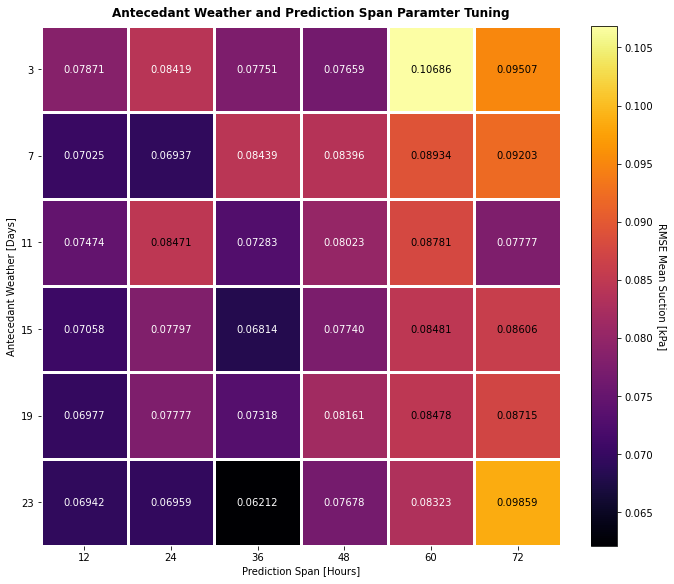

In [37]:
fig, ax = plt.subplots(figsize=(10,8), constrained_layout=True) 
fig.suptitle('Antecedant Weather and Prediction Span Paramter Tuning', fontweight="bold")

im, cbar = heatmap(mse_thresh[:,:,0], days_b, hours_f*3, ax=ax,
                   cmap="inferno", cbarlabel="RMSE Mean Suction [kPa]")
texts = annotate_heatmap(im, valfmt="{x:.5f}")
ax.set(xlabel='Prediction Span [Hours]', ylabel='Antecedant Weather [Days]')

plt.show()
#plt.savefig('./sitka_data/comparison_figs/max_pp_rmse_heatmap.png',dpi=300)

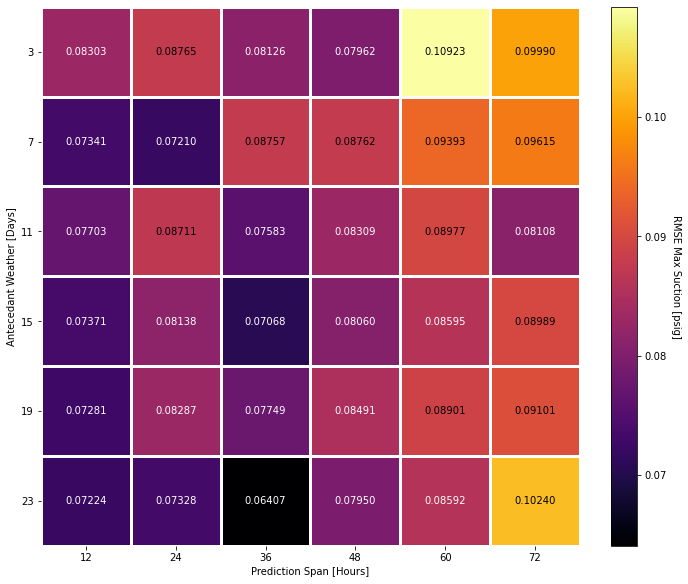

In [22]:
fig, ax = plt.subplots(figsize=(10,8), constrained_layout=True)
#fig.suptitle('Antecedant Weather and Prediction Span Paramter Tuning', fontweight="bold")

im, cbar = heatmap(mse_thresh[:,:], days_b, hours_f*3, ax=ax,
                   cmap="inferno", cbarlabel="RMSE Max Suction [psig]")
texts = annotate_heatmap(im, valfmt="{x:.5f}")
ax.set(xlabel='Prediction Span [Hours]', ylabel='Antecedant Weather [Days]')

#fig.tight_layout()
plt.savefig('./sitka_data/comparison_figs/new1_max_pp_rmse_heatmap_3-23_d_12-72_h.png')
plt.show()


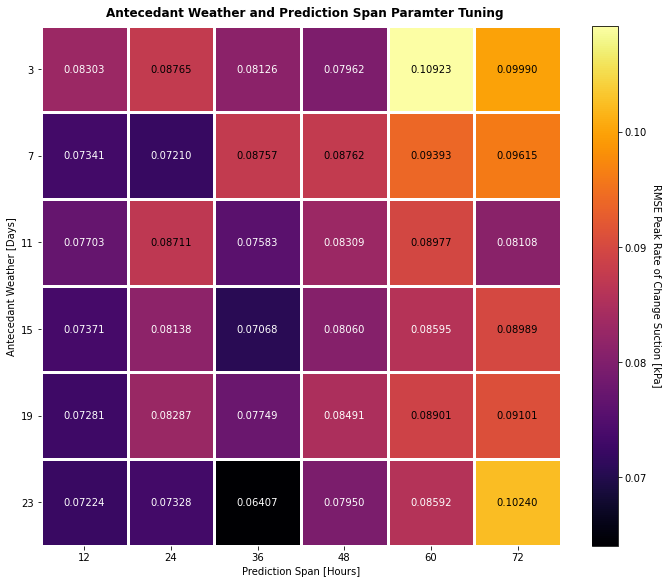

In [39]:
fig, ax = plt.subplots(figsize=(10,8), constrained_layout=True)
fig.suptitle('Antecedant Weather and Prediction Span Paramter Tuning', fontweight="bold")

im, cbar = heatmap(mse_thresh[:,:,1], days_b, hours_f*3, ax=ax,
                   cmap="inferno", cbarlabel="RMSE Peak Rate of Change Suction [kPa]")
texts = annotate_heatmap(im, valfmt="{x:.5f}")
ax.set(xlabel='Prediction Span [Hours]', ylabel='Antecedant Weather [Days]')

plt.show()
#plt.savefig('./sitka_data/comparison_figs/max_pp_rmse_heatmap.png',dpi=300)

In [7]:
# days_start = 3  # in any given run, the days_start*8 variable has to be greater than or equal to the hours_end variable
# days_interval = 4
# days_end = 24
# hours_start = 4
# hours_interval = 4
# hours_end = 24 + hours_interval
# targets = 3
# rmse_thresh = 10  # hard-coded to use 3-hour data.

# days_b = np.arange(days_start, days_end, days_interval)
# hours_f = np.arange(hours_start, hours_end, hours_interval)
# print(days_b*8)
# print(hours_f)

[ 24  56  88 120 152 184]
[ 4  8 12 16 20 24]
